# Проект по линейной регрессии

Набор данных Ames Housing состоит из числовых и категориальных признаков, где целевой переменной является цена продажи домов.

Цель этого проекта - создать модель линейной регрессии, обучить её на данных с поиском оптимальных значений параметров по сетке, и затем оценить модель на тестовом наборе данных.

### Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_absolute_error, mean_squared_error

### Данные

In [3]:
df = pd.read_csv('../data/Ames_Housing_Data.csv')

In [4]:
df.head()

,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Data columns (total 81 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   PID              2930 non-null   int64  
 1   MS SubClass      2930 non-null   int64  
 2   MS Zoning        2930 non-null   object 
 3   Lot Frontage     2440 non-null   float64
 4   Lot Area         2930 non-null   int64  
 5   Street           2930 non-null   object 
 6   Alley            198 non-null    object 
 7   Lot Shape        2930 non-null   object 
 8   Land Contour     2930 non-null   object 
 9   Utilities        2930 non-null   object 
 10  Lot Config       2930 non-null   object 
 11  Land Slope       2930 non-null   object 
 12  Neighborhood     2930 non-null   object 
 13  Condition 1      2930 non-null   object 
 14  Condition 2      2930 non-null   object 
 15  Bldg Type        2930 non-null   object 
 16  House Style      2930 non-null   object 
 17  Overall Qual  

In [6]:
# Откроем файл с перечислением признаков и их описаниями
with open('Ames_Housing_Feature_Description.txt') as f:
    print(f.read())

MSSubClass: Identifies the type of dwelling involved in the sale.	

        20	1-STORY 1946 & NEWER ALL STYLES
        30	1-STORY 1945 & OLDER
        40	1-STORY W/FINISHED ATTIC ALL AGES
        45	1-1/2 STORY - UNFINISHED ALL AGES
        50	1-1/2 STORY FINISHED ALL AGES
        60	2-STORY 1946 & NEWER
        70	2-STORY 1945 & OLDER
        75	2-1/2 STORY ALL AGES
        80	SPLIT OR MULTI-LEVEL
        85	SPLIT FOYER
        90	DUPLEX - ALL STYLES AND AGES
       120	1-STORY PUD (Planned Unit Development) - 1946 & NEWER
       150	1-1/2 STORY PUD - ALL AGES
       160	2-STORY PUD - 1946 & NEWER
       180	PUD - MULTILEVEL - INCL SPLIT LEV/FOYER
       190	2 FAMILY CONVERSION - ALL STYLES AND AGES

MSZoning: Identifies the general zoning classification of the sale.
		
       A	Agriculture
       C	Commercial
       FV	Floating Village Residential
       I	Industrial
       RH	Residential High Density
       RL	Residential Low Density
       RP	Residential Low Density Park 
       RM

## Конструирование признаков и подготовка данных

In [7]:
# Проверим, какие признаки коррелируют с целевой переменной (SalePrice)
df.corr()['SalePrice'].sort_values()

PID               -0.246521
Enclosed Porch    -0.128787
Kitchen AbvGr     -0.119814
Overall Cond      -0.101697
MS SubClass       -0.085092
Low Qual Fin SF   -0.037660
Bsmt Half Bath    -0.035835
Yr Sold           -0.030569
Misc Val          -0.015691
BsmtFin SF 2       0.005891
3Ssn Porch         0.032225
Mo Sold            0.035259
Pool Area          0.068403
Screen Porch       0.112151
Bedroom AbvGr      0.143913
Bsmt Unf SF        0.182855
Lot Area           0.266549
2nd Flr SF         0.269373
Bsmt Full Bath     0.276050
Half Bath          0.285056
Open Porch SF      0.312951
Wood Deck SF       0.327143
Lot Frontage       0.357318
BsmtFin SF 1       0.432914
Fireplaces         0.474558
TotRms AbvGrd      0.495474
Mas Vnr Area       0.508285
Garage Yr Blt      0.526965
Year Remod/Add     0.532974
Full Bath          0.545604
Year Built         0.558426
1st Flr SF         0.621676
Total Bsmt SF      0.632280
Garage Area        0.640401
Garage Cars        0.647877
Gr Liv Area        0

Наибольшую корреляцию с переменной SalePrice имеет переменная Overall Qual.
Построим график scatterplot для этих двух переменных

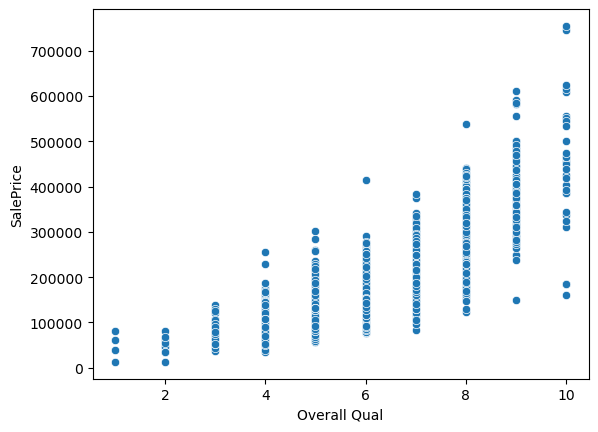

In [8]:
sns.scatterplot(x='Overall Qual', y='SalePrice', data=df);

На графике видно, что чем выше значение переменной Overall Qual, то тем выше значение SalePrice. Заметны потенциальные точки-выбросы - дома, которые продаются либо по завышенной, либо по заниженной цене.

Еще одна переменная, которая хорошо коррелирует с SalePrice - это Gr Liv Area. Построим для них график scatterplot

<AxesSubplot:xlabel='Gr Liv Area', ylabel='SalePrice'>

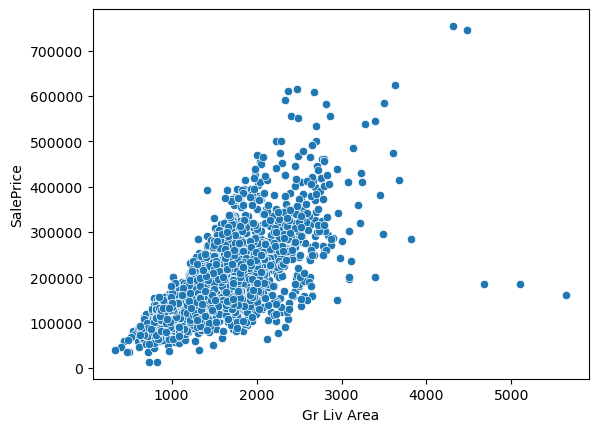

In [9]:
sns.scatterplot(x='Gr Liv Area', y='SalePrice', data=df)

На этом графике также видны точки, которые выбиваются из общей картины - дома с большой площадью, но с низкой ценой продажи. Эти точки нарушают общий тренд и соответственно могут негативно повлиять на обучение модели. И т.к. количество этих точек мало, то их можно удалить из данных.

In [10]:
# индексы точек-выбросов
drop_ind = df[(df['Gr Liv Area']>4000) & (df['SalePrice']<200000)].index
# удаление выбросов
df = df.drop(drop_ind, axis=0)

## Работа с отсутствующими данными

In [11]:
# Удалим колонку PID, т.к. она не несет никакого смысла
df = df.drop('PID', axis=1)

In [12]:
# Посмотрим сколько процентов информации отсутствует в каждой колонке
100*df.isnull().sum() / len(df)

MS SubClass        0.00000
MS Zoning          0.00000
Lot Frontage      16.74069
Lot Area           0.00000
Street             0.00000
                    ...   
Mo Sold            0.00000
Yr Sold            0.00000
Sale Type          0.00000
Sale Condition     0.00000
SalePrice          0.00000
Length: 80, dtype: float64

In [13]:
# Создадим функцию для вычисления процентов отсутствующей информации в колонках

def percent_missing(my_df):
    result = 100*my_df.isnull().sum() / len(df)
    result = result[result>0].sort_values()
    return result

In [14]:
# создадим переменную, куда включим только те данные, в которых есть отсутствующие значения
percent_nan = percent_missing(df)

In [15]:
percent_nan

Electrical         0.034165
Garage Area        0.034165
Total Bsmt SF      0.034165
Bsmt Unf SF        0.034165
BsmtFin SF 1       0.034165
BsmtFin SF 2       0.034165
Garage Cars        0.034165
Bsmt Full Bath     0.068329
Bsmt Half Bath     0.068329
Mas Vnr Area       0.785787
Mas Vnr Type       0.785787
BsmtFin Type 1     2.733174
Bsmt Qual          2.733174
Bsmt Cond          2.733174
BsmtFin Type 2     2.767339
Bsmt Exposure      2.835668
Garage Type        5.363854
Garage Finish      5.432183
Garage Qual        5.432183
Garage Cond        5.432183
Garage Yr Blt      5.432183
Lot Frontage      16.740690
Fireplace Qu      48.582166
Fence             80.457807
Alley             93.235395
Misc Feature      96.412709
Pool QC           99.590024
dtype: float64

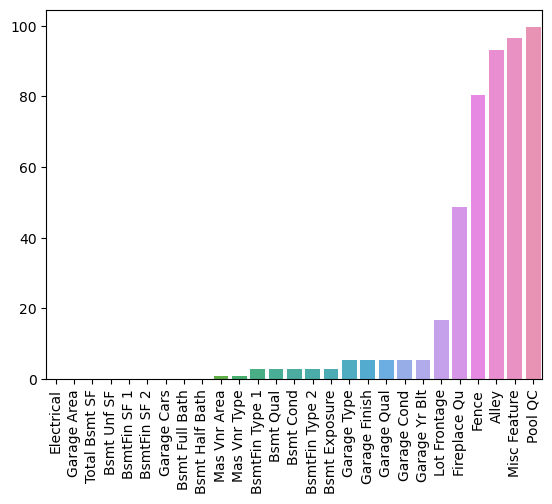

In [16]:
# Отобразим пеерменные с отсутствующими значениями (и процент отсутствующих данных)
sns.barplot(x=percent_nan.index, y=percent_nan)
plt.xticks(rotation=90);

(0.0, 1.0)

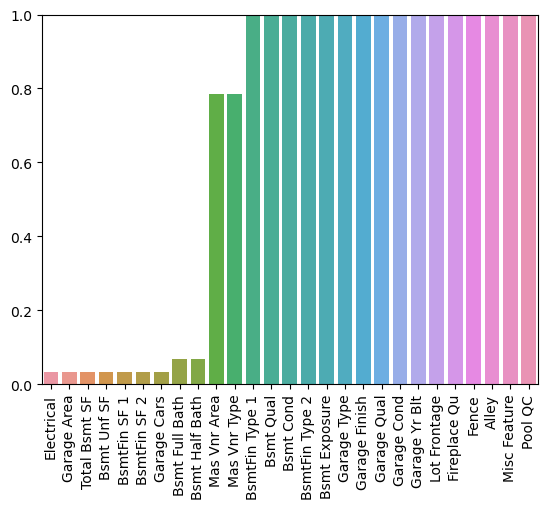

In [17]:
# Посмотрим на признаки с небольшим коичеством отсутствующих признаков (процент отсутствующих значений меньше 1)
sns.barplot(x=percent_nan.index, y=percent_nan)
plt.xticks(rotation=90)
plt.ylim(0,1)

In [18]:
# Посмотрим, какие строки имеют отсутствующие значения
percent_nan[percent_nan < 1]

Electrical        0.034165
Garage Area       0.034165
Total Bsmt SF     0.034165
Bsmt Unf SF       0.034165
BsmtFin SF 1      0.034165
BsmtFin SF 2      0.034165
Garage Cars       0.034165
Bsmt Full Bath    0.068329
Bsmt Half Bath    0.068329
Mas Vnr Area      0.785787
Mas Vnr Type      0.785787
dtype: float64

In [19]:
# В колонках Electrical, Garage Area, Total Bsmt SF, Bsmt Unf SF, BsmtFin SF 1, BsmtFin SF 2, Garage Cars имеется только по одной отсутствующей строке
# 100 / len(df) = 0,034 - т.е. 1 строка = 0,034%

In [20]:
# Удалим строки с отсутствующими значениями в колонках Electrical и Garage Area
df = df.dropna(axis=0,subset=['Electrical','Garage Area'])

In [21]:
# Посмотрим, как изменился список отсутствующих значений
percent_nan = percent_missing(df)
percent_nan[percent_nan < 1]

Bsmt Unf SF       0.034188
Total Bsmt SF     0.034188
BsmtFin SF 2      0.034188
BsmtFin SF 1      0.034188
Bsmt Full Bath    0.068376
Bsmt Half Bath    0.068376
Mas Vnr Type      0.786325
Mas Vnr Area      0.786325
dtype: float64

In [22]:
# Для колонок с параметрами подвалов заменим отсутствующие значения на 0 и None (т.к. в этих домах нет подвала)
# для числовых колонок - fillna(0)
bsmt_num_cols = ['BsmtFin SF 1', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF', 'Bsmt Full Bath', 'Bsmt Half Bath']
df[bsmt_num_cols] = df[bsmt_num_cols].fillna(0)
# для текстовых колонок
bsmt_str_cols = ['Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin Type 2']
df[bsmt_str_cols] = df[bsmt_str_cols].fillna('None')

In [23]:
percent_nan = percent_missing(df)
percent_nan[percent_nan < 1]

Mas Vnr Type    0.786325
Mas Vnr Area    0.786325
dtype: float64

(0.0, 1.0)

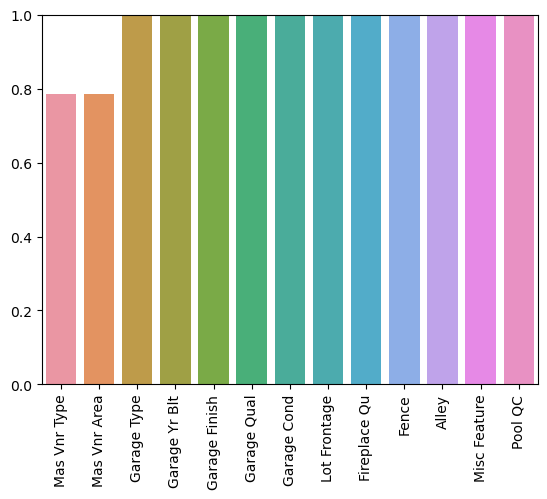

In [24]:
sns.barplot(x=percent_nan.index, y=percent_nan)
plt.xticks(rotation=90)
plt.ylim(0,1)

In [25]:
# Для признаков Mas Vnr Type и Mas Vnr Area заменим отсутствующие значения на 0 и None
df['Mas Vnr Type'] = df['Mas Vnr Type'].fillna('None')
df['Mas Vnr Area'] = df['Mas Vnr Area'].fillna(0)

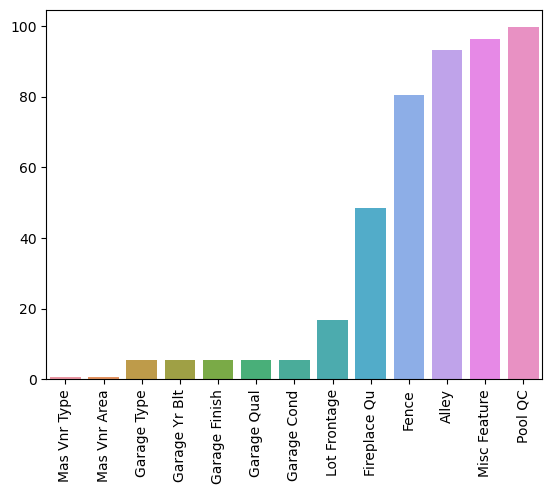

In [26]:
sns.barplot(x=percent_nan.index, y=percent_nan)
plt.xticks(rotation=90);

In [27]:
gar_str_cols = ['Garage Type', 'Garage Qual', 'Garage Finish', 'Garage Cond']
df[gar_str_cols] = df[gar_str_cols].fillna('None')

In [28]:
df['Garage Yr Blt'] = df['Garage Yr Blt'].fillna(0)

In [29]:
percent_nan = percent_missing(df)

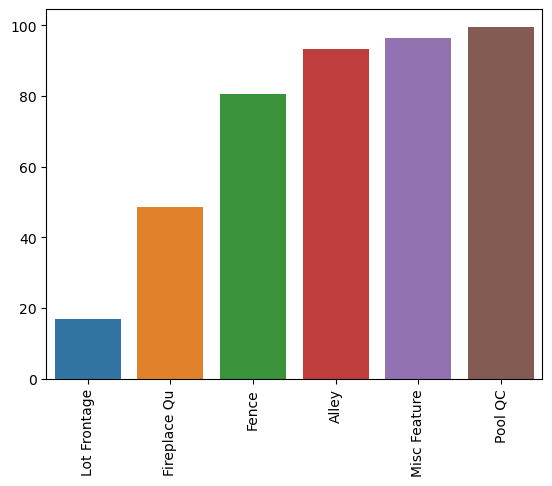

In [30]:
sns.barplot(x=percent_nan.index, y=percent_nan)
plt.xticks(rotation=90);

In [31]:
# Удалим колонки, в которых слишком большой процент отсутствующих значений
df = df.drop(['Fence', 'Alley', 'Misc Feature', 'Pool QC'], axis=1)

In [32]:
percent_nan = percent_missing(df)

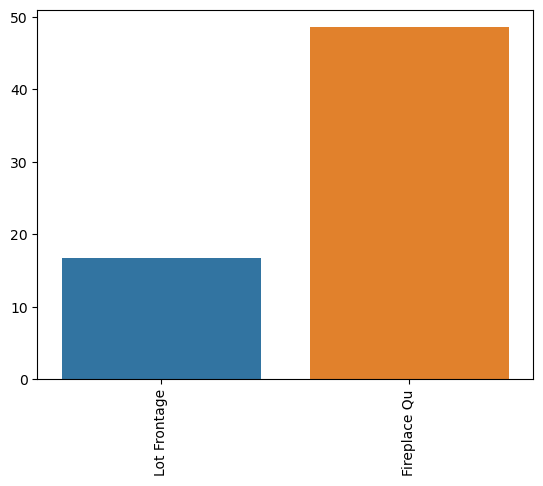

In [33]:
sns.barplot(x=percent_nan.index, y=percent_nan)
plt.xticks(rotation=90);

In [34]:
# Посмотрим на значения, которые принимает колонка Fireplace Qu
df['Fireplace Qu'].value_counts()

Gd    741
TA    600
Fa     75
Po     46
Ex     43
Name: Fireplace Qu, dtype: int64

In [35]:
# Запишем None для неопределенных значений
df['Fireplace Qu'] = df['Fireplace Qu'].fillna('None')

In [36]:
# заполним отсутствующие значения в колонке средними значениями по колонке Neighborhood
df['Lot Frontage']

0       141.0
1        80.0
2        81.0
3        93.0
4        74.0
        ...  
2925     37.0
2926      NaN
2927     62.0
2928     77.0
2929     74.0
Name: Lot Frontage, Length: 2925, dtype: float64

<AxesSubplot:xlabel='Lot Frontage', ylabel='Neighborhood'>

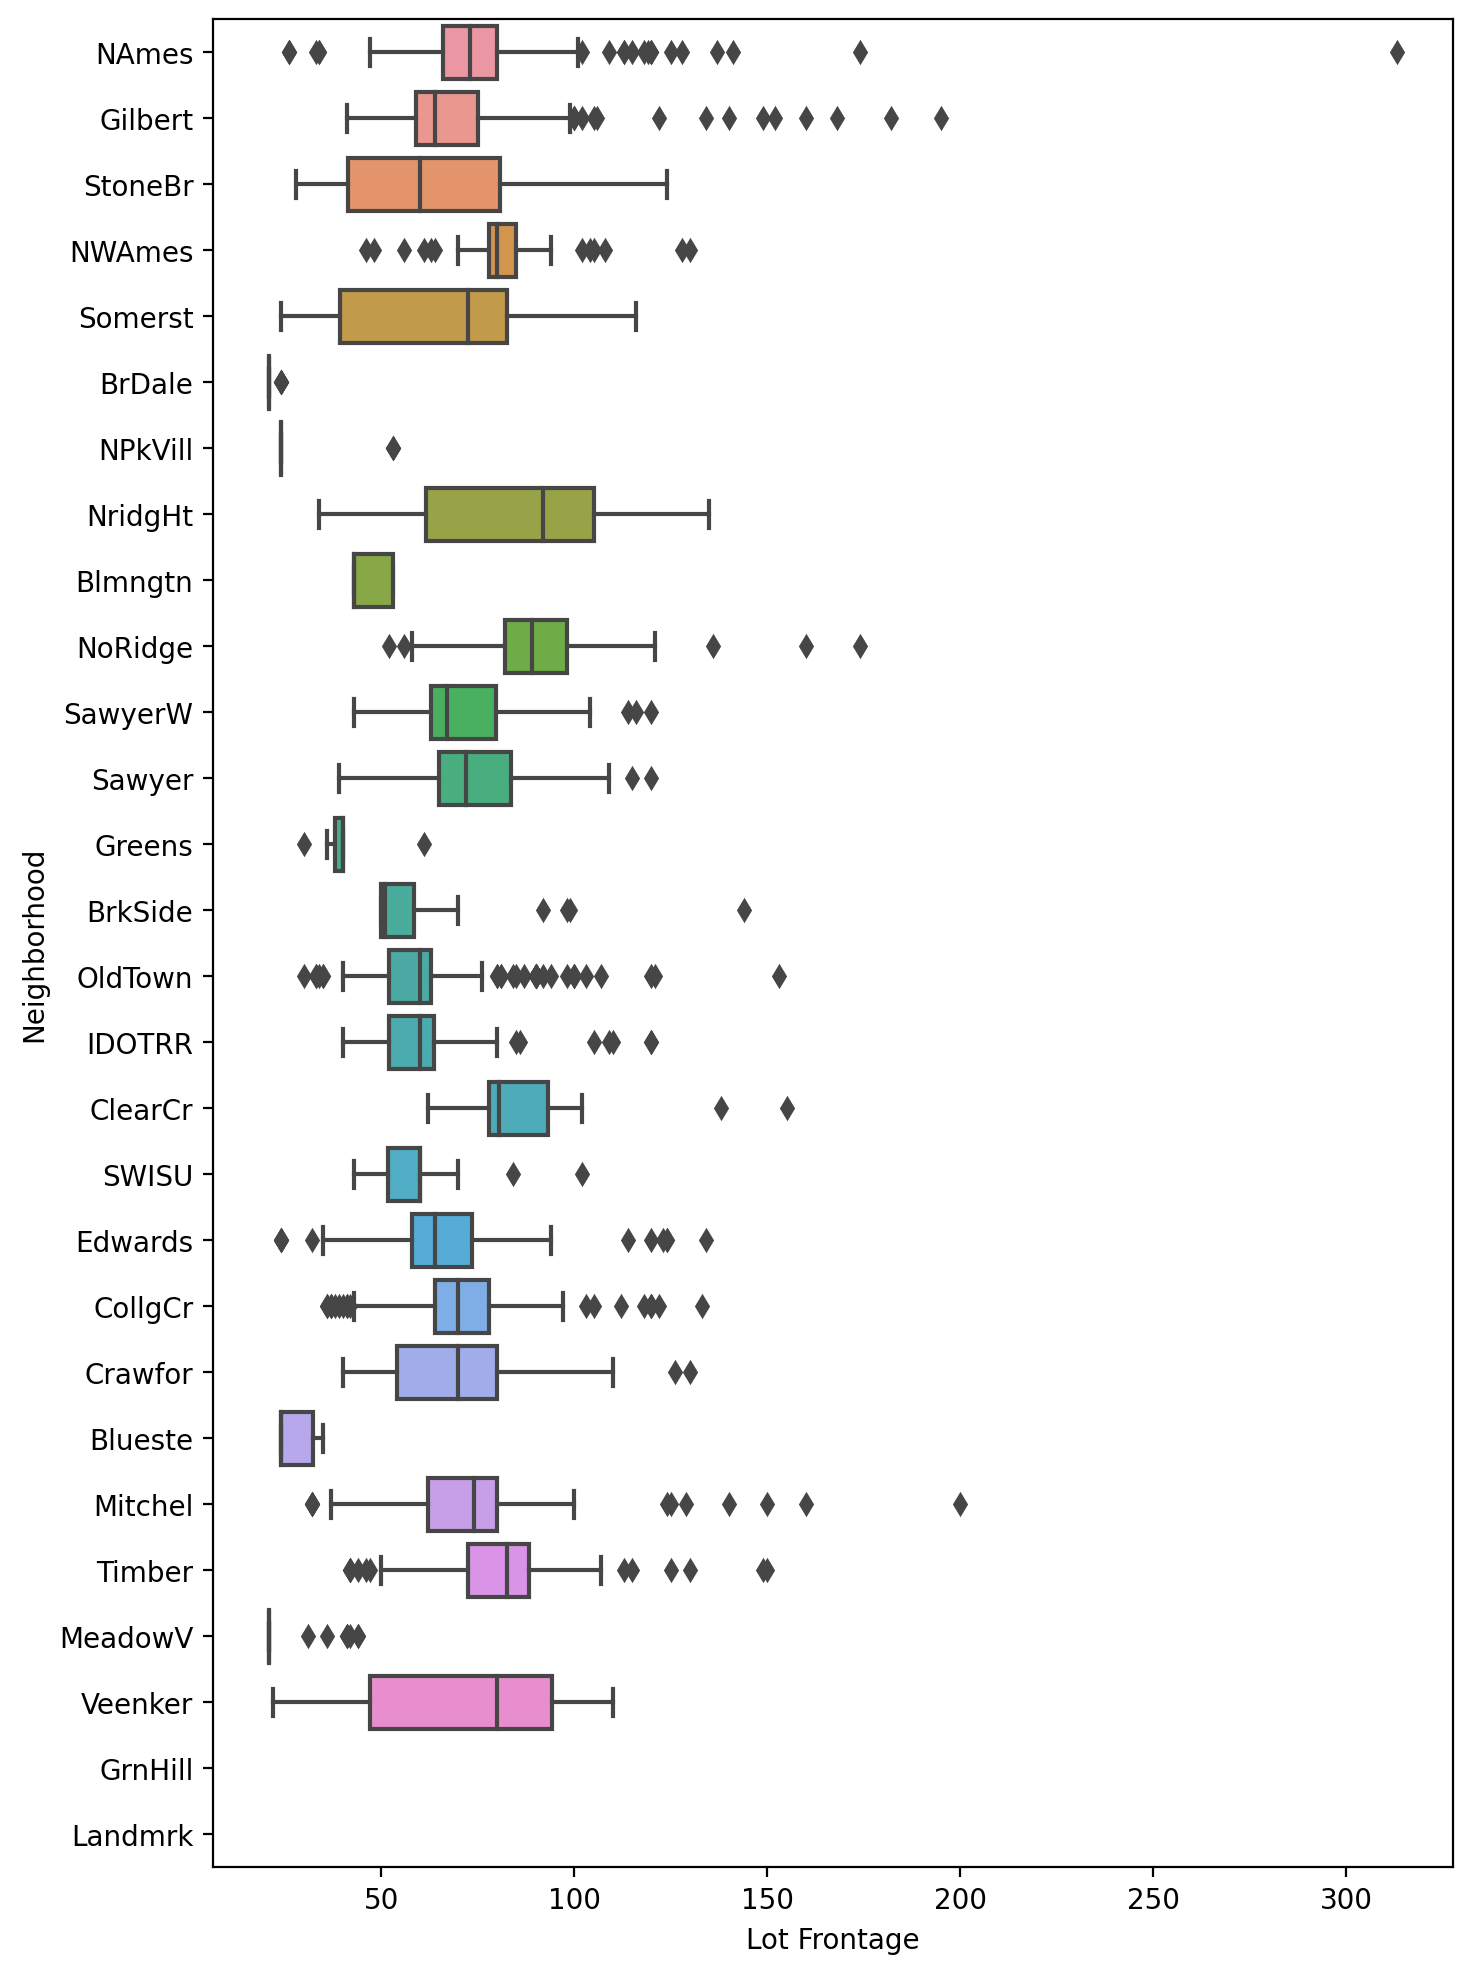

In [37]:
plt.figure(figsize=(8,12), dpi=200)
sns.boxplot(x='Lot Frontage', y='Neighborhood', data=df, orient='h')

In [38]:
# вычисляем средние знаячения по каждому району в Neighborhood
df.groupby('Neighborhood')['Lot Frontage'].mean()

Neighborhood
Blmngtn    46.900000
Blueste    27.300000
BrDale     21.500000
BrkSide    55.789474
ClearCr    88.150000
CollgCr    71.336364
Crawfor    69.951807
Edwards    64.794286
Gilbert    74.207207
Greens     41.000000
GrnHill          NaN
IDOTRR     62.383721
Landmrk          NaN
MeadowV    25.606061
Mitchel    75.144444
NAmes      75.210667
NPkVill    28.142857
NWAmes     81.517647
NoRidge    91.629630
NridgHt    84.184049
OldTown    61.777293
SWISU      59.068182
Sawyer     74.551020
SawyerW    70.669811
Somerst    64.549383
StoneBr    62.173913
Timber     81.303571
Veenker    72.000000
Name: Lot Frontage, dtype: float64

In [39]:
# заполним отсутствующие значения в Lot Frontage при помощи метода transform
df['Lot Frontage'] = df.groupby('Neighborhood')['Lot Frontage'].transform(\
                                lambda value: value.fillna(value.mean())\
                                )

In [40]:
# Количество отсутствующих значений в колонке Lot Frontage
df['Lot Frontage'].isnull().sum()

3

In [41]:
# Заменим отсутствующие значения в Lot Frontage на 0
df['Lot Frontage'] = df['Lot Frontage'].fillna(0)

In [42]:
percent_nan = percent_missing(df)

In [43]:
percent_nan

Series([], dtype: float64)

## Работа с категориальными переменными

In [44]:
# создаем dummy-переменные для колонки MS SubClass, чтобы убрать линейную шкалу, т.к. значение колонки категориальное
# переводим числовые значения в строковые
df['MS SubClass'] = df['MS SubClass'].apply(str)

In [45]:
# метод проверяет тип для каждой колонки и возвращает только колонки с указанным типом
df.select_dtypes(include='object')

,MS SubClass,MS Zoning,Street,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,...,Kitchen Qual,Functional,Fireplace Qu,Garage Type,Garage Finish,Garage Qual,Garage Cond,Paved Drive,Sale Type,Sale Condition
0,20,RL,Pave,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,...,TA,Typ,Gd,Attchd,Fin,TA,TA,P,WD,Normal
1,20,RH,Pave,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,...,TA,Typ,None,Attchd,Unf,TA,TA,Y,WD,Normal
2,20,RL,Pave,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,...,Gd,Typ,None,Attchd,Unf,TA,TA,Y,WD,Normal
3,20,RL,Pave,Reg,Lvl,AllPub,Corner,Gtl,NAmes,Norm,...,Ex,Typ,TA,Attchd,Fin,TA,TA,Y,WD,Normal
4,60,RL,Pave,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,...,TA,Typ,TA,Attchd,Fin,TA,TA,Y,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2925,80,RL,Pave,IR1,Lvl,AllPub,CulDSac,Gtl,Mitchel,Norm,...,TA,Typ,None,Detchd,Unf,TA,TA,Y,WD,Normal
2926,20,RL,Pave,IR1,Low,AllPub,Inside,Mod,Mitchel,Norm,...,TA,Typ,None,Attchd,Unf,TA,TA,Y,WD,Normal
2927,85,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,...,TA,Typ,None,None,None,None,None,Y,WD,Normal
2928,20,RL,Pave,Reg,Lvl,AllPub,Inside,Mod,Mitchel,Norm,...,TA,Typ,TA,Attchd,RFn,TA,TA,Y,WD,Normal


In [46]:
# сохраняем в переменную все текстовые колонки
my_object_df = df.select_dtypes(include='object')

In [47]:
# сохраняем в переменную все колонки, которые не являются текстовыми
my_numeric_df = df.select_dtypes(exclude='object')

In [48]:
# создаем dummy-переменную для всех текстовых колонок
df_objects_dummies = pd.get_dummies(my_object_df, drop_first=True)

In [49]:
# объединяем такстовые колонки с числовыми в финальный DataFrame
final_df = pd.concat([my_numeric_df, df_objects_dummies], axis=1)

In [50]:
final_df

,Lot Frontage,Lot Area,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Mas Vnr Area,BsmtFin SF 1,BsmtFin SF 2,Bsmt Unf SF,...,Sale Type_ConLw,Sale Type_New,Sale Type_Oth,Sale Type_VWD,Sale Type_WD,Sale Condition_AdjLand,Sale Condition_Alloca,Sale Condition_Family,Sale Condition_Normal,Sale Condition_Partial
0,141.000000,31770,6,5,1960,1960,112.0,639.0,0.0,441.0,...,0,0,0,0,1,0,0,0,1,0
1,80.000000,11622,5,6,1961,1961,0.0,468.0,144.0,270.0,...,0,0,0,0,1,0,0,0,1,0
2,81.000000,14267,6,6,1958,1958,108.0,923.0,0.0,406.0,...,0,0,0,0,1,0,0,0,1,0
3,93.000000,11160,7,5,1968,1968,0.0,1065.0,0.0,1045.0,...,0,0,0,0,1,0,0,0,1,0
4,74.000000,13830,5,5,1997,1998,0.0,791.0,0.0,137.0,...,0,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2925,37.000000,7937,6,6,1984,1984,0.0,819.0,0.0,184.0,...,0,0,0,0,1,0,0,0,1,0
2926,75.144444,8885,5,5,1983,1983,0.0,301.0,324.0,239.0,...,0,0,0,0,1,0,0,0,1,0
2927,62.000000,10441,5,5,1992,1992,0.0,337.0,0.0,575.0,...,0,0,0,0,1,0,0,0,1,0
2928,77.000000,10010,5,5,1974,1975,0.0,1071.0,123.0,195.0,...,0,0,0,0,1,0,0,0,1,0


## Построение и оценка модели машинного обучения

In [51]:
# Разделяем данные на две части - признаки Х и целевая переменная y
X = final_df.drop('SalePrice', axis=1)
y = final_df['SalePrice']

In [52]:
# Разобьем все данные на обучающий и тестовый наборы
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=101)

In [53]:
# Признаки в этом наборе данных имеют различный масштаб и различные единицы измерения
# Для оптимальной работы регрессии, выполним масштабирование признаков X
scaler = StandardScaler()
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)

In [54]:
# Создадим экземпляр модели ElasticNet в scikit-learn, используя параметры по умолчанию
base_elastic_model = ElasticNet(max_iter=1000000)

In [55]:
# Модель Elastic Net работает с двумя основными параметрами - alpha и L1_ratio
# Создадим словарь с набором различных значений этих параметров, для поиска по сетке
param_grid = {'alpha':[0.1, 1, 5, 10, 100], 'l1_ratio':[0.1, 0.7, 0.99, 1]}

In [56]:
# Создадим объект GridSearchCV и запустим поиск по сетке для нахождения наилучших параметров модели
grid_model = GridSearchCV(base_elastic_model, 
                          param_grid=param_grid, 
                          scoring='neg_mean_squared_error', 
                          cv=5, 
                          verbose=1)

In [57]:
grid_model.fit(scaled_X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


GridSearchCV(cv=5, estimator=ElasticNet(max_iter=1000000),
             param_grid={'alpha': [0.1, 1, 5, 10, 100],
                         'l1_ratio': [0.1, 0.7, 0.99, 1]},
             scoring='neg_mean_squared_error', verbose=1)

In [58]:
# Отобразим наилучшие параметры для модели
grid_model.best_params_

{'alpha': 100, 'l1_ratio': 1}

In [59]:
# Оценим работу модели на тестовом наборе данных
y_pred = grid_model.predict(scaled_X_test)

In [60]:
mean_absolute_error(y_test, y_pred)

14195.354900562168

In [61]:
np.sqrt(mean_squared_error(y_test, y_pred))

20558.508566893164

In [62]:
# Для оценки того, насколько хороши получившиеся показатели сравним их со средним значением целевой переменной
np.mean(df['SalePrice'])

180815.53743589742

Ошибки - 14195 и 20558 находятся примерно в диапазоне 10% от средней стоимости дома (180815), т.е получившаяся модель дает предсказание цены которая в среднем на 10% отличается от истинного значения